In [1]:
#!pip install BeautifulSoup4

In [2]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from xgboost import XGBRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
link_IPEA = "http://www.ipeadata.gov.br/ExibeSerie.aspx?module=m&serid=1650971490&oper=view"
requisicao = requests.get(link_IPEA)

In [4]:
#Atualização dos dados
from datetime import datetime

def update_dataframe(df, new_data):
    df['Data'] = pd.to_datetime(df['Data'], dayfirst= True)
    new_data['Data'] = pd.to_datetime(new_data['Data'], dayfirst=True)
    
    last_date = df['Data'].max()
    
    new_rows = new_data[new_data['Data'] > last_date]
    
    if not new_rows.empty:
        updated_df = pd.concat([df, new_rows], ignore_index=True)
    else:
        updated_df = df
    return updated_df

In [5]:
#path_git = 'https://raw.githubusercontent.com/BrunoSlemer/IPEA-Analytics/main/ipea.csv'
path = 'D:/Fiap/TechChallenge/04/ipea.csv'

if requisicao.status_code == 200:
    html_ipea = BeautifulSoup(requisicao.text, "html.parser")
    tabela_ipea = html_ipea.find('table', {"id":"grd_DXMainTable"})
    
    df_ipea = pd.read_html(str(tabela_ipea), header=0)[0]
    
    try:
        existing_df = pd.read_csv(path)
    except FileNotFoundError:
        existing_df = df_ipea
        
    updated_df = update_dataframe(existing_df, df_ipea)
    updated_df.to_csv(path,sep=',', header= True, index=False)
    
    updated_df.head(10)
else:
    print("Erro na requisição: ",requisicao.status_code)

### EDA

In [6]:
df = pd.read_csv("ipea.csv", sep = ',', date_parser='Data')
#df["Preço - petróleo bruto - Brent (FOB)"] = df["Preço - petróleo bruto - Brent (FOB)"]/100
df['Data'] = pd.to_datetime(df['Data'], format='%Y-%m-%d')


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11092 entries, 0 to 11091
Data columns (total 2 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Data                                  11092 non-null  datetime64[ns]
 1   Preço - petróleo bruto - Brent (FOB)  11092 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 173.4 KB


In [8]:
df = df.sort_values(by= 'Data', ascending= True)
df

,Data,Preço - petróleo bruto - Brent (FOB)
11091,1987-05-20,18.63
11090,1987-05-21,18.45
11089,1987-05-22,18.55
11088,1987-05-25,18.60
11087,1987-05-26,18.63
...,...,...
4,2024-01-16,80.15
3,2024-01-17,78.88
2,2024-01-18,81.04
1,2024-01-19,80.71


In [9]:
print(df['Data'].min())
print(df['Data'].max())

1987-05-20 00:00:00
2024-01-22 00:00:00


In [10]:
melhores_dias = df.sort_values('Preço - petróleo bruto - Brent (FOB)',ascending=True).head(10)
piores_dias = df.sort_values('Preço - petróleo bruto - Brent (FOB)',ascending=False).head(10)
print(f'Melhores dias: {melhores_dias}\n')
print(f'Piores dias: {piores_dias}')
# 2020-04-21 quase bateu minima historica

Melhores dias:            Data  Preço - petróleo bruto - Brent (FOB)
8154 1998-12-10                                  9.10
955  2020-04-21                                  9.12
8153 1998-12-11                                  9.26
8147 1998-12-21                                  9.45
8152 1998-12-14                                  9.45
8155 1998-12-09                                  9.46
8151 1998-12-15                                  9.57
8148 1998-12-18                                  9.62
8156 1998-12-08                                  9.68
8157 1998-12-07                                  9.70

Piores dias:            Data  Preço - petróleo bruto - Brent (FOB)
5046 2008-07-07                                143.95
5050 2008-07-03                                143.95
5038 2008-07-15                                143.68
5035 2008-07-18                                142.43
5047 2008-07-06                                141.24
5051 2008-07-02                                141.24

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
print('Numero de a mostras -> ', len(df), "| Média:", round(df['Preço - petróleo bruto - Brent (FOB)'].mean()), ' | Devio padrão', round(df['Preço - petróleo bruto - Brent (FOB)'].std()))

Numero de a mostras ->  11092 | Média: 53  | Devio padrão 33


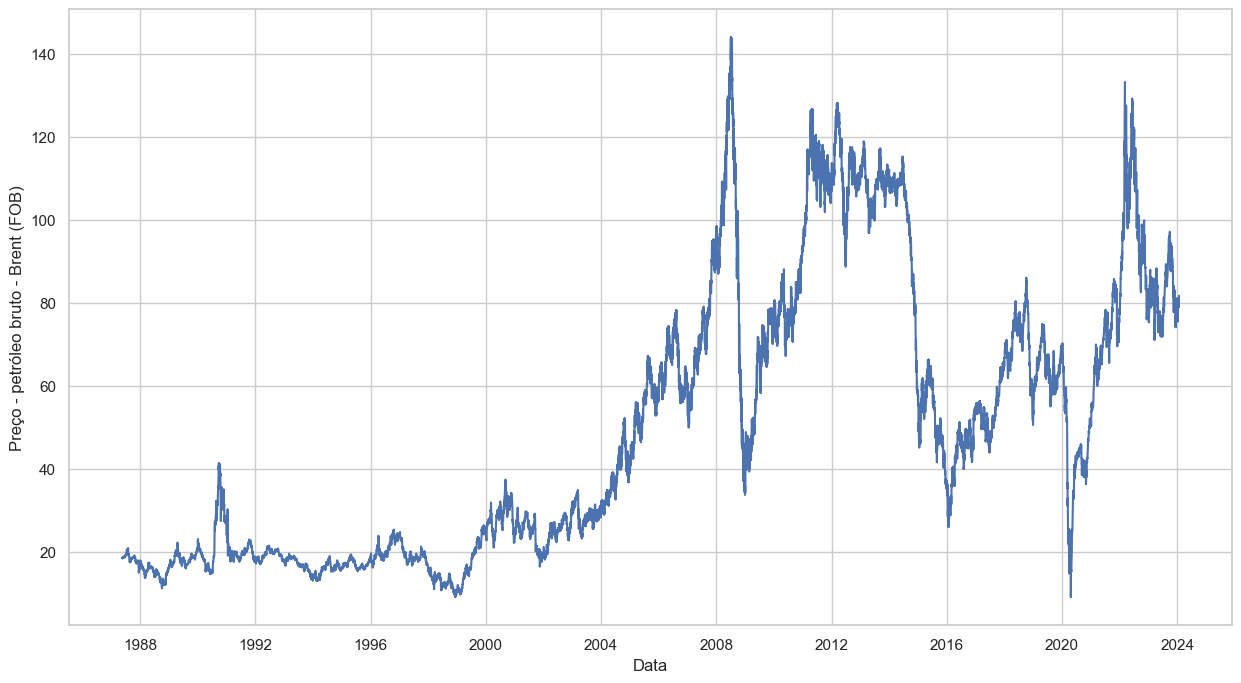

In [13]:
sns.set(style="whitegrid")
plt.figure(figsize=(15,8))
sns.lineplot(x='Data', y='Preço - petróleo bruto - Brent (FOB)', data=df)
plt.show()

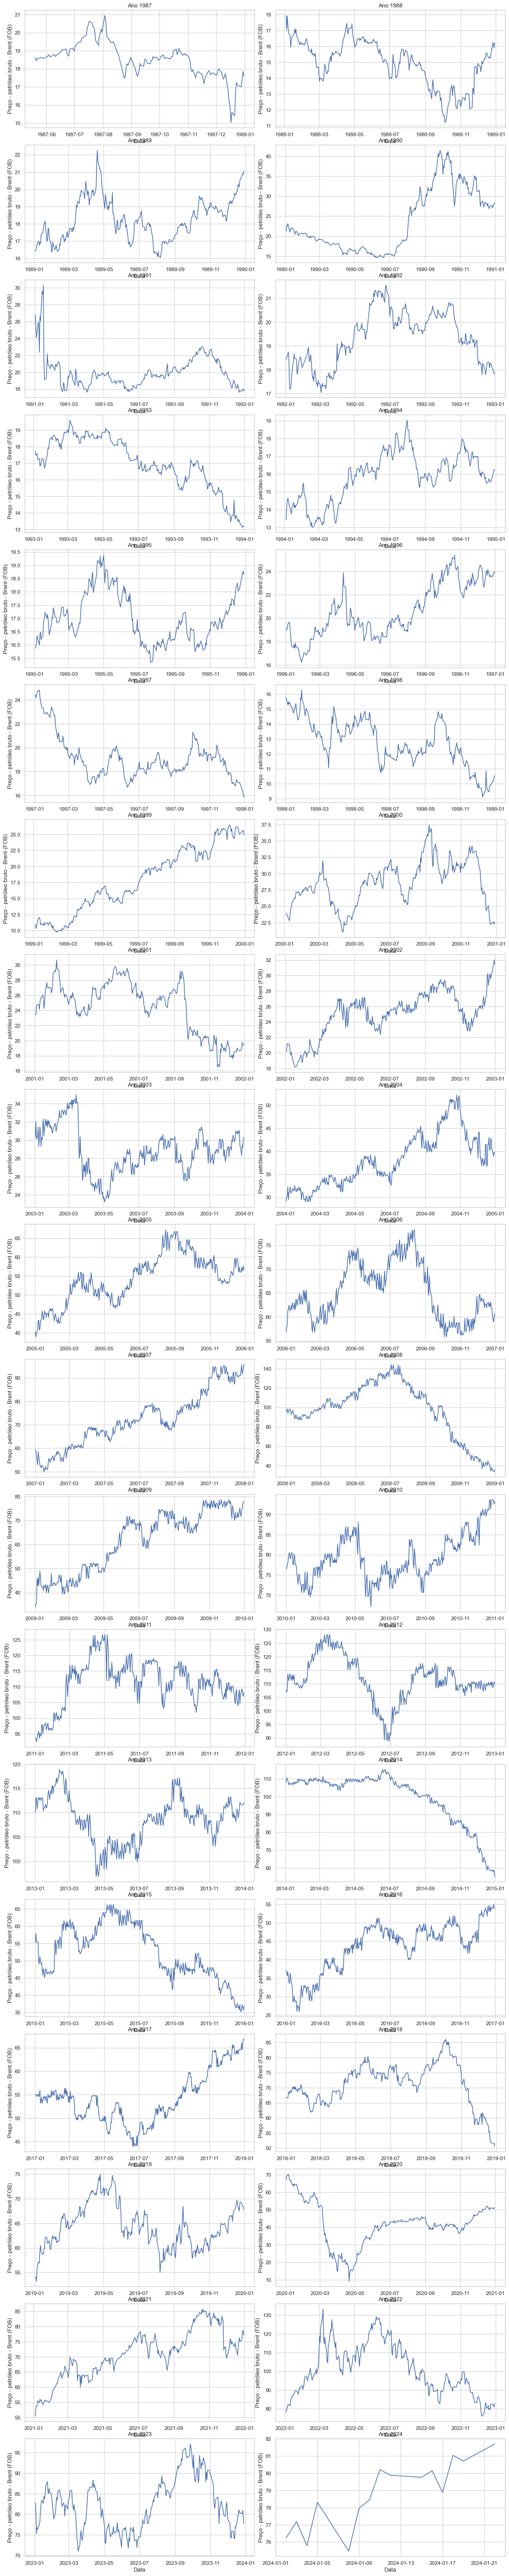

In [14]:
# gráfico por ano
df['Data'] = pd.to_datetime(df['Data'])
df['Ano'] = df['Data'].dt.year

sns.set(style="whitegrid")

anos = df['Ano'].unique()

colunas_por_linha = 2

num_linhas = -(-len(anos) // colunas_por_linha)

fig, axs = plt.subplots(num_linhas, colunas_por_linha, figsize=(15, num_linhas * 4), sharey=False)
plt.tight_layout()

for i, ano in enumerate(anos):
   
    linha = i // colunas_por_linha
    coluna = i % colunas_por_linha

    dados_ano = df[df['Ano'] == ano]

    sns.lineplot(x='Data', y='Preço - petróleo bruto - Brent (FOB)', data=dados_ano, ax=axs[linha, coluna])

    axs[linha, coluna].set_title(f'Ano {ano}')
    

plt.show()


In [15]:
df['Preço - petróleo bruto - Brent (FOB)'].describe()

count    11092.000000
mean        52.796398
std         33.230129
min          9.100000
25%         20.407500
50%         47.900000
75%         75.750000
max        143.950000
Name: Preço - petróleo bruto - Brent (FOB), dtype: float64

In [16]:
# Para melhorar a janela de observação, resolvemos criar um novo dataframe com os dados acumulados por ano com:
# Valores estatiscos de maxima, minima, media e devio padrão
# Incluimos a "Variação acumulada " para uma anlise em valor de retorno e não nominal
# E incluimos o retorno acumulado ao multiplicar o primeiro valor da base dividir por cada elemente do ano para medir a tendencia dos ganhos 

estatisticas_df = pd.DataFrame(columns=['Ano', 'Máximo', 'Mínimo', 'Média', 'Desvio Padrão','Retorno acumulado','Variação'])

for i, ano in enumerate(anos):
    dados_ano = df[df['Ano'] == ano]
    maximo = dados_ano['Preço - petróleo bruto - Brent (FOB)'].max()
    minimo = dados_ano['Preço - petróleo bruto - Brent (FOB)'].min()
    media = dados_ano['Preço - petróleo bruto - Brent (FOB)'].mean()
    std = dados_ano['Preço - petróleo bruto - Brent (FOB)'].std()
    primeiro_elemento = dados_ano['Preço - petróleo bruto - Brent (FOB)'].iloc[0]
    soma = (dados_ano['Preço - petróleo bruto - Brent (FOB)'] / primeiro_elemento).sum()
    var = dados_ano['Preço - petróleo bruto - Brent (FOB)'].pct_change().sum()
    
    estatisticas_ano = pd.DataFrame({'Ano': [ano],
                                     'Máximo': [maximo],
                                     'Mínimo': [minimo],
                                     'Média': [media],
                                     'Desvio Padrão': [std],
                                     'Retorno acumulado': [soma],
                                     'Variação': [var]})
    
    estatisticas_df = pd.concat([estatisticas_df, estatisticas_ano], ignore_index=True)



In [17]:
estatisticas_df.sort_values('Ano', ascending=False).head(40)


,Ano,Máximo,Mínimo,Média,Desvio Padrão,Retorno acumulado,Variação
37,2024,81.70,75.47,78.784000,1.952474,15.500525,0.072023
36,2023,97.10,71.03,82.355538,6.085644,249.592369,-0.007137
35,2022,133.18,76.02,100.881875,13.433276,330.041661,0.167581
34,2021,85.76,50.37,70.852677,8.031027,357.287671,0.485119
33,2020,70.25,9.12,41.710817,12.015907,159.875913,0.386599
32,2019,74.94,53.23,64.136780,4.380269,313.209582,0.279718
31,2018,86.07,50.57,71.289873,6.863963,335.859265,-0.231974
30,2017,66.80,43.98,54.163691,5.338196,357.805641,0.245972
29,2016,54.95,26.01,43.506230,6.708857,429.430421,0.568049
28,2015,66.33,35.26,52.543014,7.812359,346.991134,-0.239452


In [18]:
# Criamos um validador binario para contabilizar os anos onde a varaição acumulada foi positiva
estatisticas_df['positivo'] = np.where(estatisticas_df['Variação'] > 0,1,-1)
estatisticas_df.sort_values('Variação', ascending=True).head(10)
print(estatisticas_df['positivo'].value_counts())
print(len(estatisticas_df))
estatisticas_df.to_csv('estatisticas_por_ano.csv',sep=',', header= True, index=False)

 1    25
-1    13
Name: positivo, dtype: int64
38


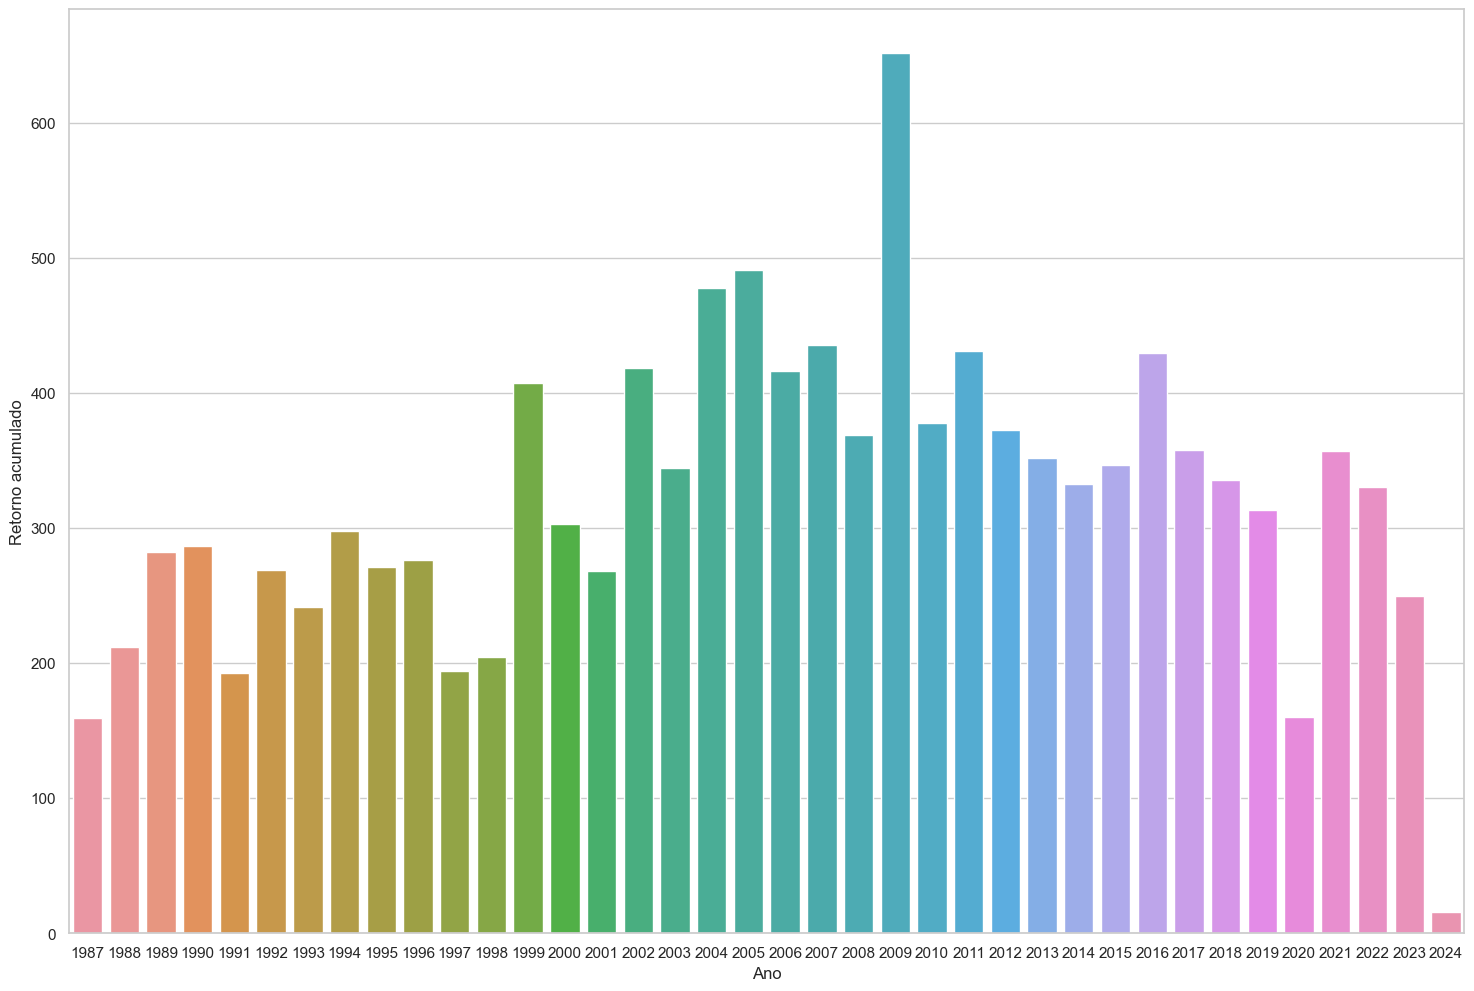

In [19]:
sns.set(style="whitegrid")
plt.figure(figsize=(18,12))
sns.barplot(x='Ano', y='Retorno acumulado', data= estatisticas_df)
plt.show()


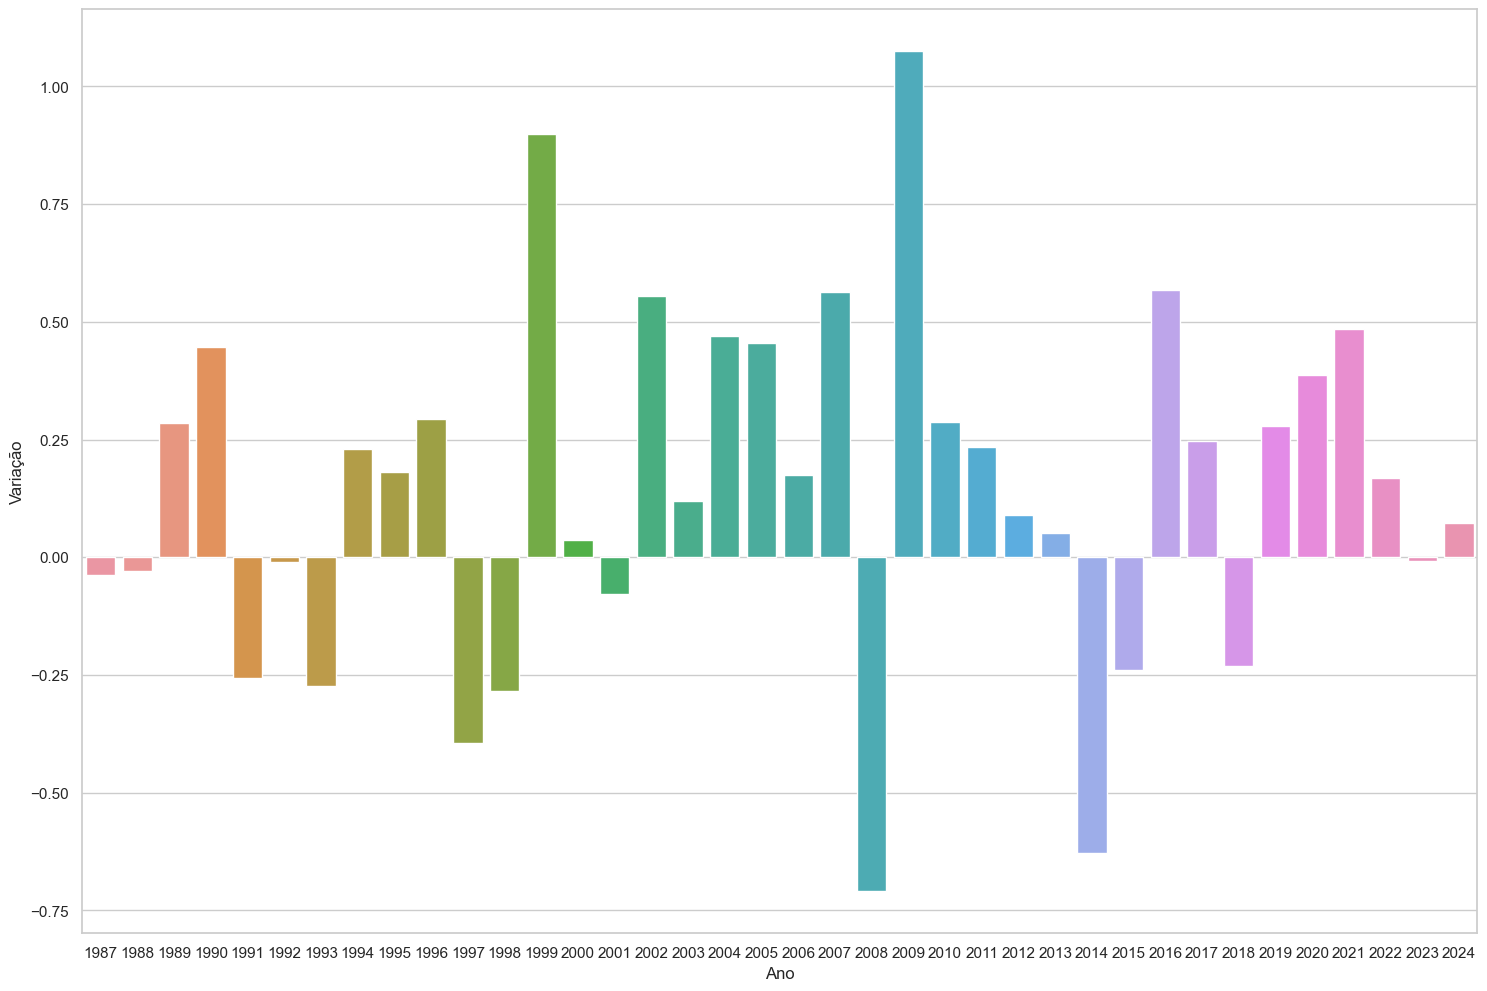

In [20]:
sns.set(style="whitegrid")
plt.figure(figsize=(18,12))
sns.barplot(x='Ano', y='Variação', data= estatisticas_df)
plt.show()

#### O grafico do retorno acumulado se assemelha a uma curva gausiana inclinda para direita, mas é mais destacado por apresentar valores de de pico sempre adjacentes aos anos de variação negativa oque implica na capacidade de recuperação de preco do ativo

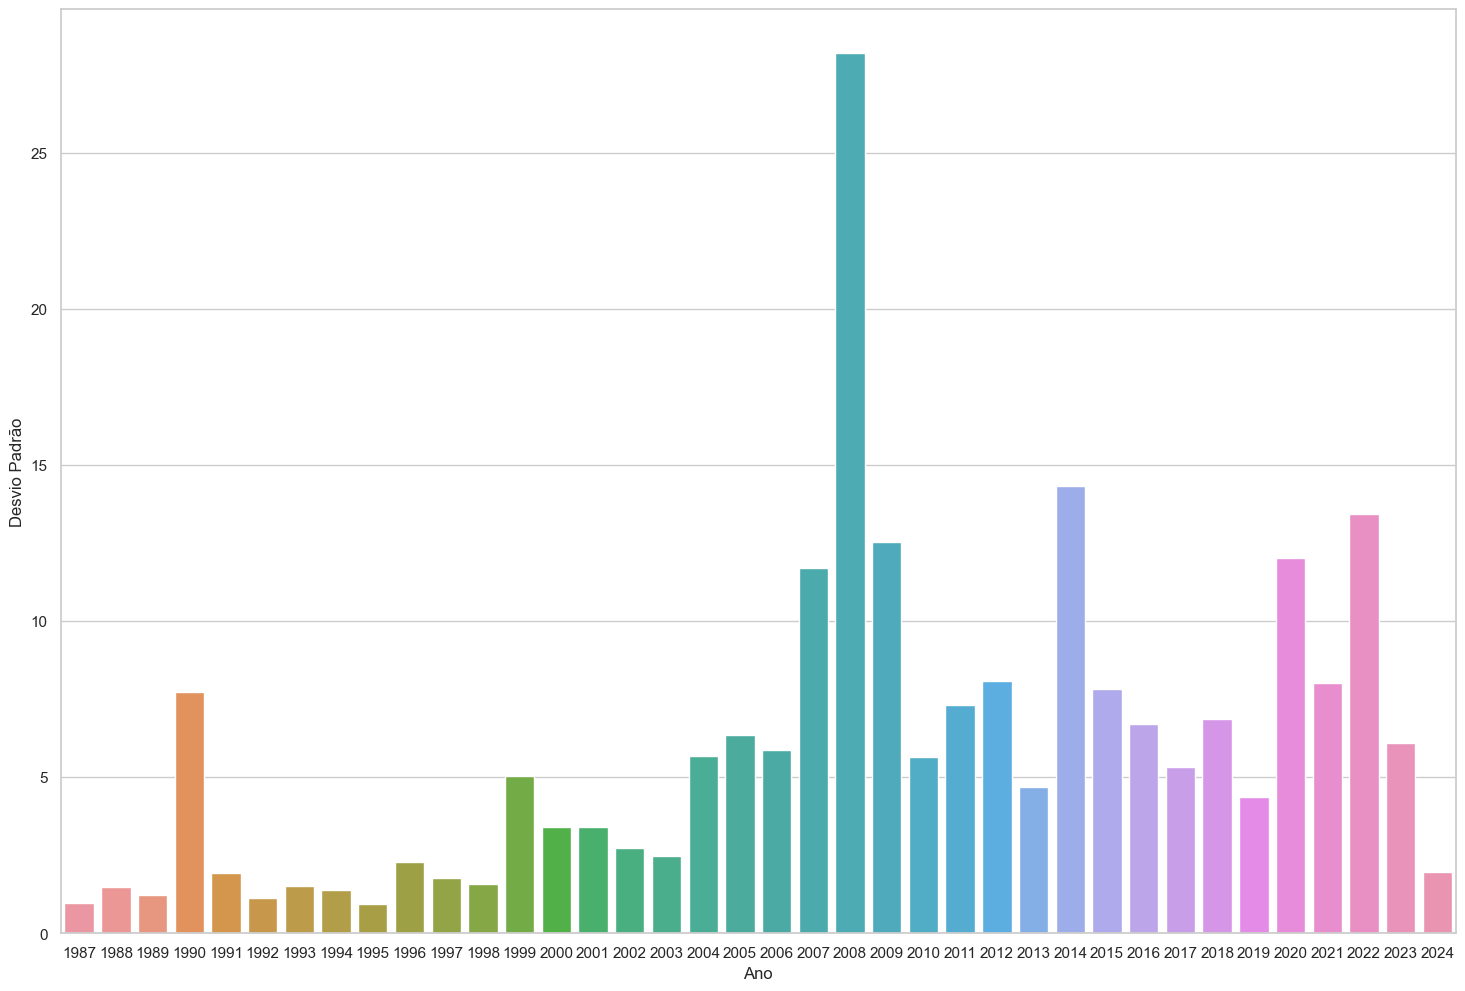

In [21]:
sns.set(style="whitegrid")
plt.figure(figsize=(18,12))
sns.barplot(x='Ano', y='Desvio Padrão', data= estatisticas_df)
plt.show()

In [22]:
df = df.set_index('Data')

### Analise da Serie Temporal

In [23]:
df

,Preço - petróleo bruto - Brent (FOB),Ano
Data,,
1987-05-20,18.63,1987
1987-05-21,18.45,1987
1987-05-22,18.55,1987
1987-05-25,18.60,1987
1987-05-26,18.63,1987
...,...,...
2024-01-16,80.15,2024
2024-01-17,78.88,2024
2024-01-18,81.04,2024


In [24]:
result = seasonal_decompose(df['Preço - petróleo bruto - Brent (FOB)'], period= 365)

seasonal = result.seasonal
trend = result.trend
resid = result.resid
observed = result.observed

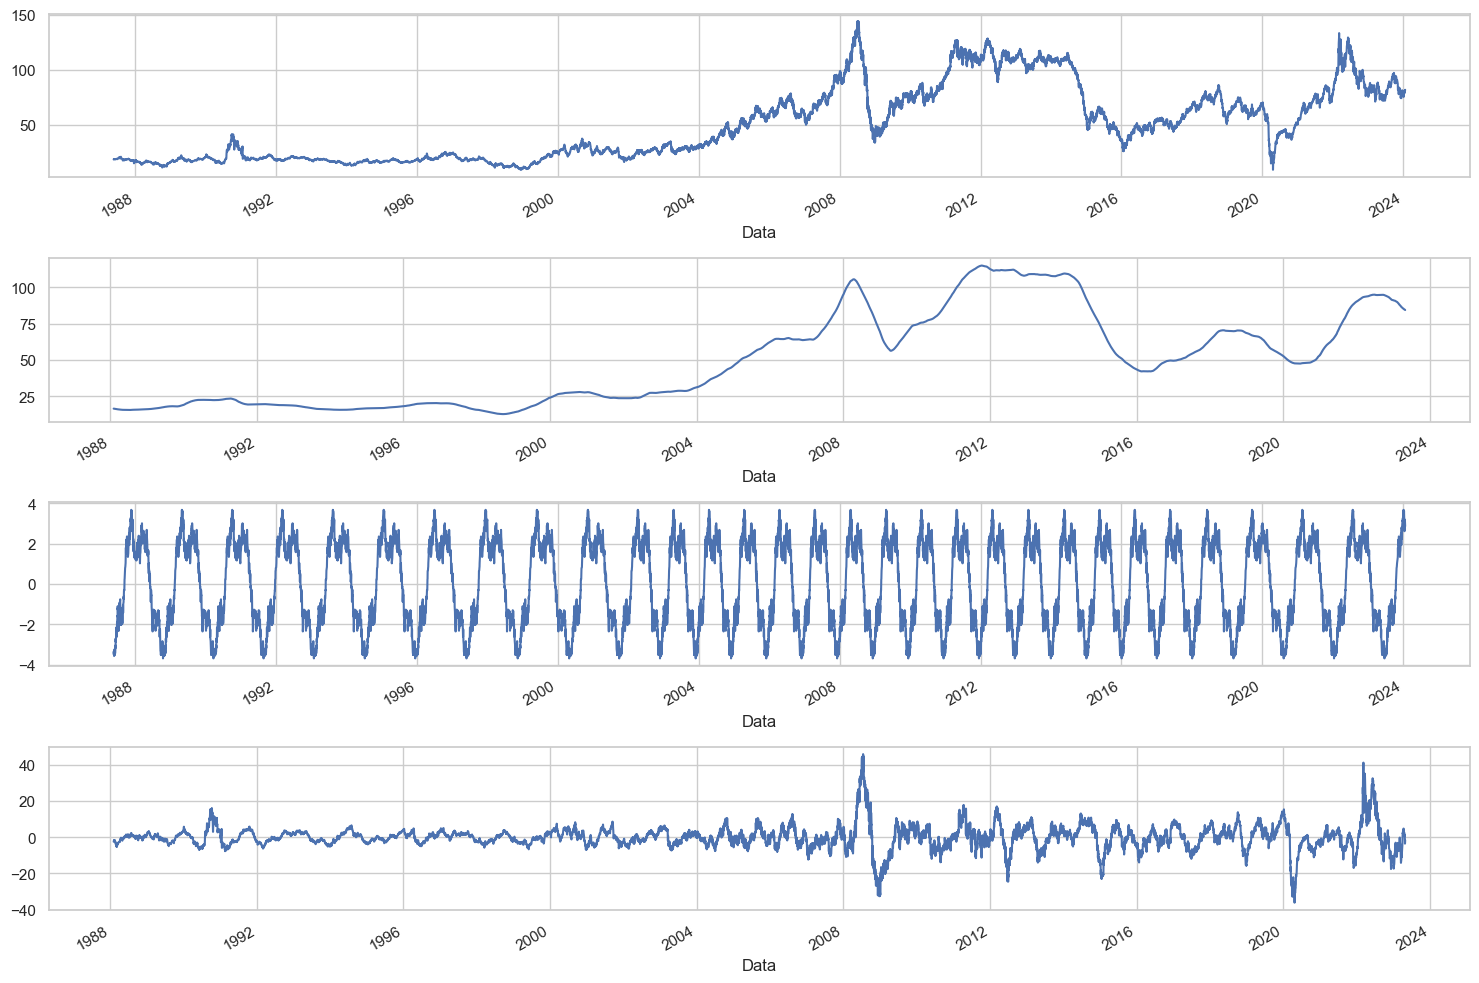

In [25]:
fig, (ax1, ax2, ax3 ,ax4) = plt.subplots(4,1, figsize=(15,10))

observed.plot(ax= ax1)
trend.plot(ax=ax2)
seasonal.plot(ax= ax3)
resid.plot(ax=ax4)

plt.tight_layout()

### Teste ADF

In [26]:
from statsmodels.tsa.stattools import adfuller
sns.set_style('darkgrid')

def adfuller_test(df):
    X = df['Preço - petróleo bruto - Brent (FOB)'].values

    result = adfuller(X)

    print("Teste ADF")
    print(f"Teste Estatiscio: {result[0]}")
    print(f"P-Value: {result[1]}")
    print("Valores Criticos:")

    for x, value in result[4].items():
        print(f"\t{x}: {value}")
    
adfuller_test(df)
#p-valor é aproximadamente 0.2556, o que significa que não há evidência suficiente para rejeitar a hipótese nula, portanto a serie não é estacionmaria

Teste ADF
Teste Estatiscio: -2.0728408614179594
P-Value: 0.25557470042168684
Valores Criticos:
	1%: -3.4309413940660836
	5%: -2.861801363756628
	10%: -2.566909118804548


In [27]:
# tranformação logaritmima para diminuir a discrepancia na scala dos valores
df_log = np.log(df['Preço - petróleo bruto - Brent (FOB)'])
# realizando diferenciação para viabilizar uso do modelo ARIMA
df_diff = df_log.diff(1)
X_diff = df_diff.dropna().values
result_diff = adfuller(X_diff)
print("Teste ADF")
print(f"Teste Estatiscio: {result_diff[0]}")
print(f"P-Value: {result_diff[1]}")
print("Valores Criticos:")

# com uma diferenciação já é possivel deixar a serie estacionaria

Teste ADF
Teste Estatiscio: -19.125850944354102
P-Value: 0.0
Valores Criticos:


C:\Users\T-Gamer\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


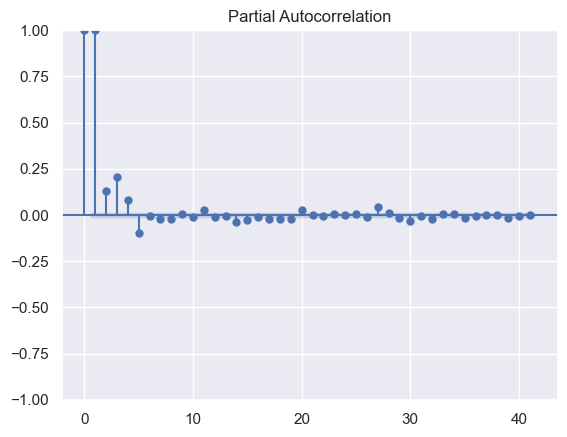

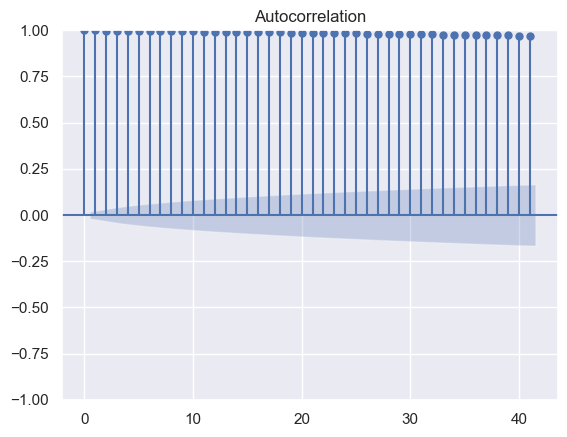

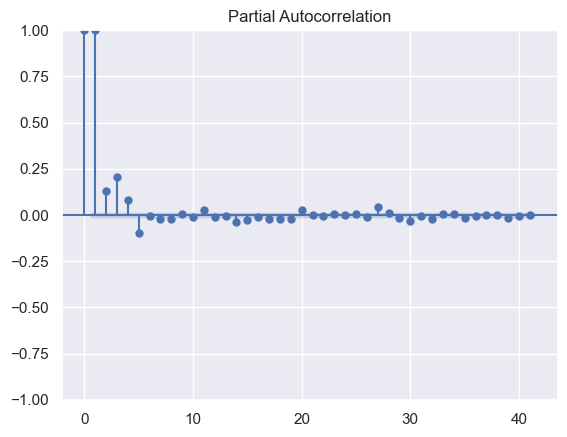

In [28]:
plot_acf(df['Preço - petróleo bruto - Brent (FOB)'].dropna())
plot_pacf(df['Preço - petróleo bruto - Brent (FOB)'].dropna())

In [29]:

##Para identificar o modelo que mais se adapata a analise da serie temporal, utilizamos uma função em loop testando um conjunto de modelos sem ajuste, e como o objetivo é realizar uma previsão utilizamo, raiz erro quadratico médio como validação
series = df.drop(['Ano'],axis=1)
scaler = StandardScaler()
rmse_values = []

def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

def model_fit_predict(model, train, test):
    train_dates = (train.index - train.index[0]).days.values.reshape(-1, 1)
    test_dates = (test.index - train.index[0]).days.values.reshape(-1, 1)
    model.fit(train_dates, train.values)
    predictions = model.predict(test_dates)
    return predictions

def measure_rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

def run():

    scaled_data = scaler.fit_transform(series.values.reshape(-1, 1))

    normalized_series = pd.Series(scaled_data.flatten(), index=series.index)

    train, test = train_test_split(normalized_series, 30)

    models = [ARIMA(train, order=(1,1,0)), LinearRegression(), SVR(), GradientBoostingRegressor(), XGBRegressor()]

    for model in models:
        if type(model) is ARIMA:
            model_fit = model.fit()
            predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
        else:
            predictions = model_fit_predict(model, train, test)

        # Desnormalizar as previsões antes de calcular o RMSE
        predictions_unscaled = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
        test_unscaled = scaler.inverse_transform(test.values.reshape(-1, 1)).flatten()
        rmse = measure_rmse(test_unscaled, predictions_unscaled)
        print(f'RMSE: {rmse} for model {type(model).__name__}')
        
      
run()

C:\Users\T-Gamer\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\T-Gamer\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\T-Gamer\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\T-Gamer\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_ind

RMSE: 4.764550447415282 for model ARIMA
RMSE: 15.292711124929017 for model LinearRegression
RMSE: 13.644682477086244 for model SVR
RMSE: 2.9458729360723788 for model GradientBoostingRegressor
RMSE: 7.4122855792082785 for model XGBRegressor


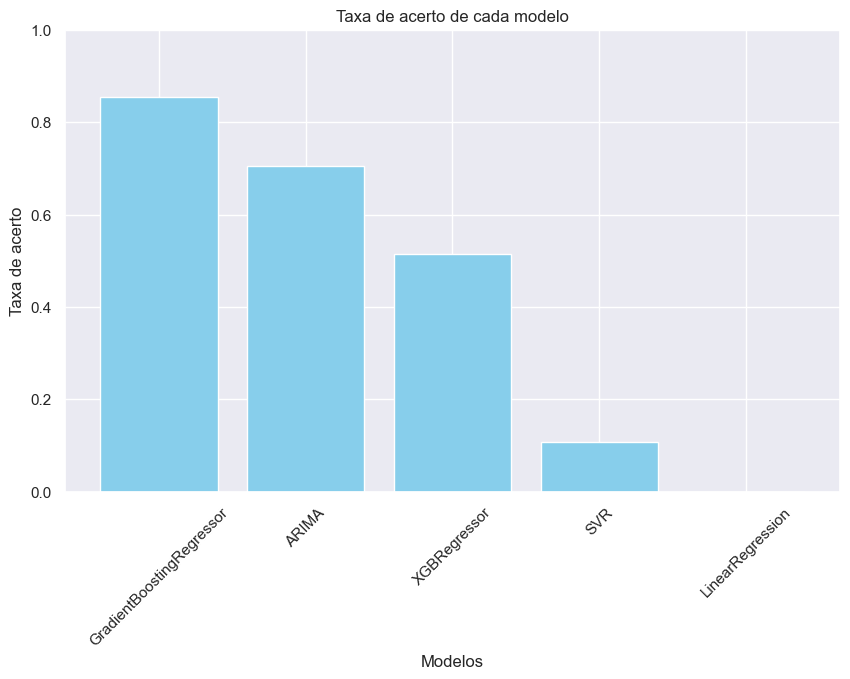

In [30]:
rmse_values = [4.522449990221025, 15.292711124929017, 13.644682477086244, 2.2283690885269256, 7.4122855792082785]
model_names = ["ARIMA", "LinearRegression", "SVR", "GradientBoostingRegressor", "XGBRegressor"]

max_reference = max(rmse_values)
accuracy_rates = [1 - rmse / max_reference for rmse in rmse_values]

# Criar o gráfico de barras ordenado do melhor para o pior
sorted_indices = sorted(range(len(accuracy_rates)), key=lambda i: accuracy_rates[i], reverse=True)
sorted_model_names = [model_names[i] for i in sorted_indices]
sorted_accuracy_rates = [accuracy_rates[i] for i in sorted_indices]

plt.figure(figsize=(10, 6))
plt.bar(sorted_model_names, sorted_accuracy_rates, color='skyblue')
plt.xlabel('Modelos')
plt.ylabel('Taxa de acerto')
plt.title('Taxa de acerto de cada modelo')
plt.xticks(rotation=45)  
plt.ylim(0, 1)
plt.show()

In [31]:
df.drop('Ano', inplace=True, axis=1)
df.reset_index(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11092 entries, 0 to 11091
Data columns (total 2 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Data                                  11092 non-null  datetime64[ns]
 1   Preço - petróleo bruto - Brent (FOB)  11092 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 173.4 KB


Mean Squared Error: 3.706288641323741


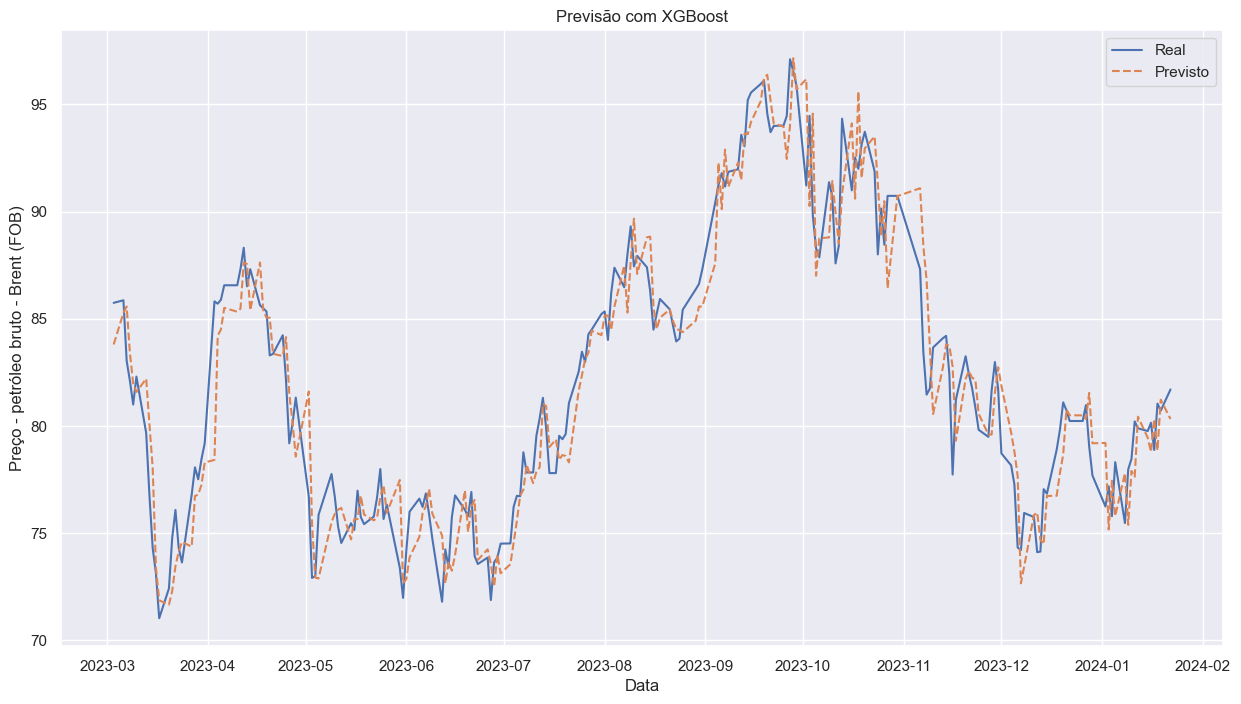

In [32]:
# apesar de realizada a contrução do modelo em XGBRegressor, o modelo GradientBoostingRegressor teve desempenho superior
for i in range(1, 6):  # Criando lags de 1 a 5 períodos
    df[f'Valor_Lag_{i}'] = df['Preço - petróleo bruto - Brent (FOB)'].shift(i)

df = df.dropna()

train_size = int(len(df) * 0.98)
train, test = df[:train_size], df[train_size:]


X_train, y_train = train.drop(['Data', 'Preço - petróleo bruto - Brent (FOB)'], axis=1), train['Preço - petróleo bruto - Brent (FOB)']
X_test, y_test = test.drop(['Data', 'Preço - petróleo bruto - Brent (FOB)'], axis=1), test['Preço - petróleo bruto - Brent (FOB)']

model = XGBRegressor()
model.fit(X_train, y_train)

predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

# Visualizar as previsões
plt.figure(figsize=(15, 8))
plt.plot(test['Data'], y_test, label='Real')
plt.plot(test['Data'], predictions, label='Previsto', linestyle='dashed')
plt.title('Previsão com XGBoost')
plt.xlabel('Data')
plt.ylabel('Preço - petróleo bruto - Brent (FOB)')
plt.legend()
plt.show()

In [33]:
df_pred = pd.DataFrame(columns={"pred"},data=predictions)
df_teste = pd.DataFrame(y_test)

In [34]:
df_teste.reset_index(drop=True,inplace = True)
df_pred.reset_index(drop=True, inplace = True)

In [35]:
df_teste['value'] = np.where(df_pred['pred'] > df_teste['Preço - petróleo bruto - Brent (FOB)'],1,-1)

In [36]:
print(df_teste['value'].sum())
print(len(df_teste))

print((222-44)/2)

-20
222
89.0


In [37]:
df_gb = df.drop(df.columns[2:], axis=1)
df_gb = df.set_index('Data')
df_gb.head()

,Preço - petróleo bruto - Brent (FOB),Valor_Lag_1,Valor_Lag_2,Valor_Lag_3,Valor_Lag_4,Valor_Lag_5
Data,,,,,,
1987-05-27,18.60,18.63,18.60,18.55,18.45,18.63
1987-05-28,18.60,18.60,18.63,18.60,18.55,18.45
1987-05-29,18.58,18.60,18.60,18.63,18.60,18.55
1987-06-01,18.65,18.58,18.60,18.60,18.63,18.60
1987-06-02,18.68,18.65,18.58,18.60,18.60,18.63


In [38]:
from sklearn.model_selection import train_test_split

Lag: 7, Max Depth: 9, Mean Squared Error: 0.27321786461405245
Lag: 8, Max Depth: 9, Mean Squared Error: 0.2599857684736149
Lag: 9, Max Depth: 9, Mean Squared Error: 0.2520881861723884
Melhor MSE: 0.2520881861723884


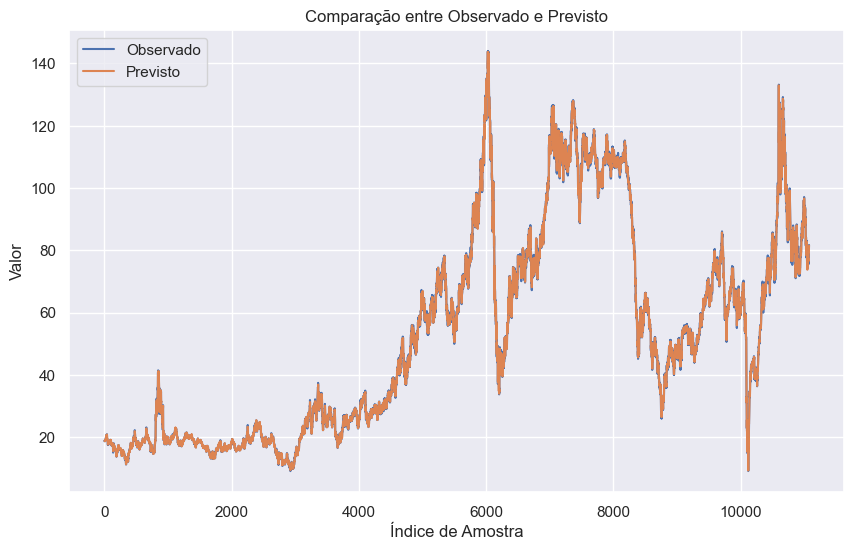

In [39]:
def create_features_target(data, lag=1):
    X = []
    y = []
    for i in range(len(data) - lag):
        X.append(data[i:i+lag])
        y.append(data[i+lag])
    return np.array(X), np.array(y)

def train_gb_regressor(X_train, y_train, n_estimators=100, max_depth=3, learning_rate=0.1):

    gb_model = GradientBoostingRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)
    gb_model.fit(X_train, y_train)
    return gb_model

lag_range = range(7, 10)
max_depth_range = range(9, 10)
n_estimators = 100
learning_rate = 0.1


best_model = None
best_mse = float('inf')

for lag in lag_range:

    X, y = create_features_target(df_gb['Preço - petróleo bruto - Brent (FOB)'], lag=lag)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)
    for max_depth in max_depth_range:

        X_train_lag, y_train_lag = create_features_target(df_gb['Preço - petróleo bruto - Brent (FOB)'], lag=lag)
        X_test_lag, y_test_lag = create_features_target(df_gb['Preço - petróleo bruto - Brent (FOB)'], lag=lag)
        
        gb_model = train_gb_regressor(X_train_lag, y_train_lag, n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)
        
        y_pred = gb_model.predict(X_test_lag)
        mse = mean_squared_error(y_test_lag, y_pred)
        print(f"Lag: {lag}, Max Depth: {max_depth}, Mean Squared Error: {mse}")
        
     
        if mse < best_mse:
            best_mse = mse
            best_model = gb_model

print("Melhor MSE:", best_mse)


plt.figure(figsize=(10, 6))
plt.plot(y_test_lag, label='Observado')
plt.plot(y_pred, label='Previsto')
plt.xlabel('Índice de Amostra')
plt.ylabel('Valor')
plt.title('Comparação entre Observado e Previsto')
plt.legend()
plt.show()


Lag: 1, Max Depth: 1, Mean Squared Error: 2.848419138482761, Rmse: 1.6877260258948314
Lag: 1, Max Depth: 2, Mean Squared Error: 2.04663628980465, Rmse: 1.4306069655236024
Lag: 1, Max Depth: 3, Mean Squared Error: 1.8923189157375722, Rmse: 1.3756158314506168
Lag: 1, Max Depth: 4, Mean Squared Error: 1.814848787435667, Rmse: 1.347163237115557
Lag: 1, Max Depth: 5, Mean Squared Error: 1.7168642922381028, Rmse: 1.310291682122001
Lag: 1, Max Depth: 6, Mean Squared Error: 1.6039000975166706, Rmse: 1.2664517746510013
Lag: 1, Max Depth: 7, Mean Squared Error: 1.4269483900707425, Rmse: 1.1945494506594285
Lag: 1, Max Depth: 8, Mean Squared Error: 1.2403137525081944, Rmse: 1.113693742690599
Lag: 1, Max Depth: 9, Mean Squared Error: 1.0915358158009199, Rmse: 1.0447659143563786
Lag: 2, Max Depth: 1, Mean Squared Error: 2.8349923743279852, Rmse: 1.6837435595505585
Lag: 2, Max Depth: 2, Mean Squared Error: 2.0173841929024223, Rmse: 1.4203465045200845
Lag: 2, Max Depth: 3, Mean Squared Error: 1.829209

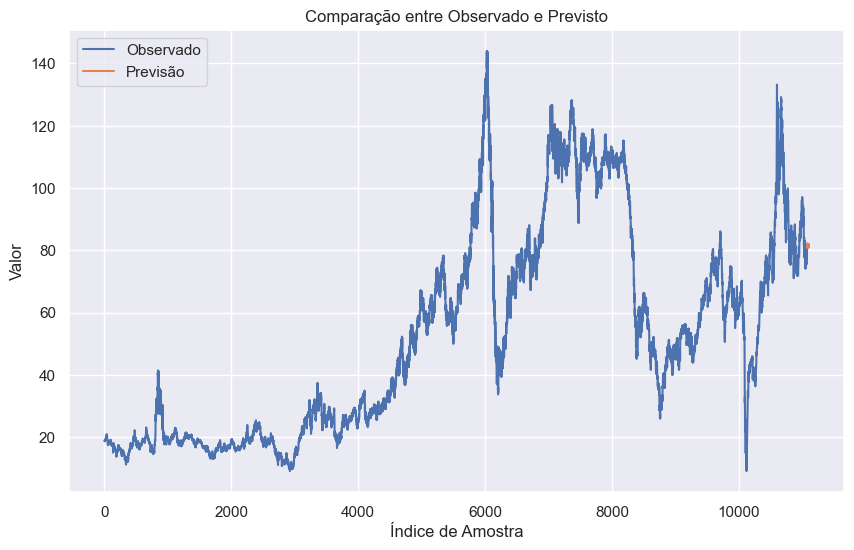

In [40]:
def create_features_target(data, lag=1):

    X = []
    y = []
    for i in range(len(data) - lag):
        X.append(data[i:i+lag])
        y.append(data[i+lag])
    return np.array(X), np.array(y)

def train_gb_regressor(X_train, y_train, n_estimators=100, max_depth=3, learning_rate=0.1):

    gb_model = GradientBoostingRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)
    gb_model.fit(X_train, y_train)
    return gb_model

lag_range = range(1, 10)
max_depth_range = range(1, 10)
n_estimators = 100
learning_rate = 0.1
prediction_days = 30

best_model = None
best_mse = float('inf')

for lag in lag_range:

    X, y = create_features_target(df_gb['Preço - petróleo bruto - Brent (FOB)'], lag=lag)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)
    for max_depth in max_depth_range:

        X_train_lag, y_train_lag = create_features_target(df_gb['Preço - petróleo bruto - Brent (FOB)'], lag=lag)
        X_test_lag, y_test_lag = create_features_target(df_gb['Preço - petróleo bruto - Brent (FOB)'], lag=lag)
        
        gb_model = train_gb_regressor(X_train_lag, y_train_lag, n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)
        

        y_pred = gb_model.predict(X_test_lag)
        mse = mean_squared_error(y_test_lag, y_pred)
        rmse = np.sqrt(mse)
        print(f"Lag: {lag}, Max Depth: {max_depth}, Mean Squared Error: {mse}, Rmse: {rmse}")
        

        if mse < best_mse:
            best_mse = mse
            best_model = gb_model

X_pred = df_gb['Preço - petróleo bruto - Brent (FOB)'][-lag:].values.reshape(1, -1)  
forecast = []
for _ in range(prediction_days):
    next_day_pred = best_model.predict(X_pred)
    forecast.append(next_day_pred)
    X_pred = np.append(X_pred[:, 1:], next_day_pred).reshape(1, -1)


print("Melhor MSE: ", best_mse)
plt.figure(figsize=(10, 6))
plt.plot(y_test_lag, label='Observado')
plt.plot(np.arange(len(y_test_lag), len(y_test_lag) + len(forecast)), forecast, label='Previsão')
plt.xlabel('Índice de Amostra')
plt.ylabel('Valor')
plt.title('Comparação entre Observado e Previsto')
plt.legend()
plt.show()


In [41]:
df_lag5 = pd.DataFrame(y_test_lag, columns=['valor_lag5'])
#df_lag5

In [42]:
df_lag5['value'] = np.where(y_pred > y_test_lag,1,-1)

In [43]:
df_lag5

,valor_lag5,value
0,18.78,-1
1,18.78,-1
2,18.68,1
3,18.78,-1
4,18.90,-1
...,...,...
11073,80.15,-1
11074,78.88,1
11075,81.04,-1
11076,80.71,1


In [44]:
print(df_lag5['value'].sum())
print(len(df_lag5))

print((222-44)/2)

-28
11078
89.0


In [45]:
forecast_pred = np.append(forecast,forecast)
forecast_pred
def ajustar_para_dataframe(dados, data_inicial):
    # Gerar datas a partir da data inicial
    datas = pd.date_range(start=data_inicial, periods=len(dados), freq='D')
    
    # Criar DataFrame
    df = pd.DataFrame({'Data': datas, 'Valor': [valor[0] for valor in dados]})
    
    return df

data_inicial = '2024-01-23'

new_forecast = ajustar_para_dataframe(forecast, data_inicial)

# Exibir o DataFrame
print(new_forecast)


         Data      Valor
0  2024-01-23  81.318843
1  2024-01-24  81.418184
2  2024-01-25  81.147128
3  2024-01-26  82.253874
4  2024-01-27  81.896060
5  2024-01-28  80.704927
6  2024-01-29  81.561422
7  2024-01-30  81.957944
8  2024-01-31  81.303166
9  2024-02-01  81.824589
10 2024-02-02  81.548974
11 2024-02-03  81.686364
12 2024-02-04  80.913733
13 2024-02-05  81.336324
14 2024-02-06  81.590384
15 2024-02-07  81.054265
16 2024-02-08  81.322416
17 2024-02-09  81.519758
18 2024-02-10  80.926574
19 2024-02-11  81.539095
20 2024-02-12  81.429675
21 2024-02-13  81.050008
22 2024-02-14  81.585112
23 2024-02-15  81.565656
24 2024-02-16  81.243188
25 2024-02-17  81.894697
26 2024-02-18  81.416956
27 2024-02-19  81.686364
28 2024-02-20  81.777037
29 2024-02-21  81.560384


Lag: 9, Max Depth: 9, Mean Squared Error: 0.2520881861723883


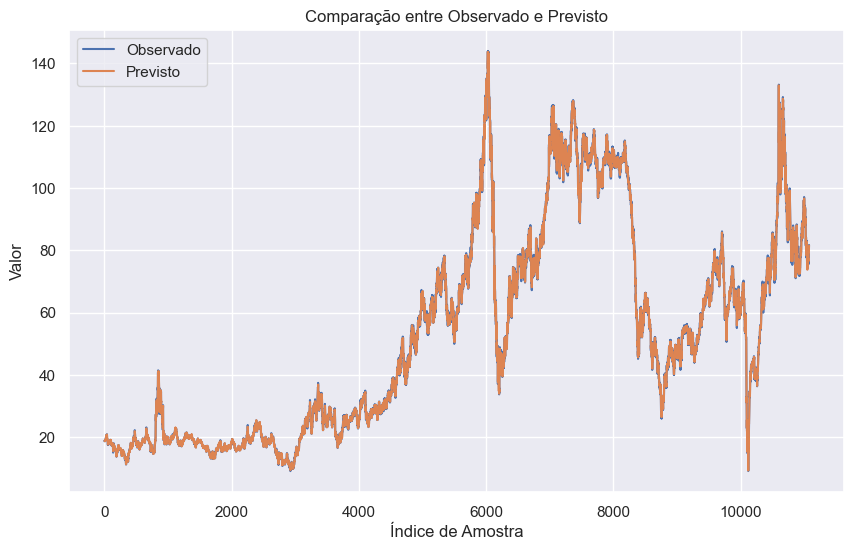

In [48]:
import pickle

def create_features_target(data, lag=1):
    X = []
    y = []
    for i in range(len(data) - lag):
        X.append(data[i:i+lag])
        y.append(data[i+lag])
    return np.array(X), np.array(y)

def train_gb_regressor(X_train, y_train, n_estimators=100, max_depth=3, learning_rate=0.1):

    gb_model = GradientBoostingRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)
    gb_model.fit(X_train, y_train)
    return gb_model

lag = 9
max_depth = 9
n_estimators = 100
learning_rate = 0.1


best_model = None
best_mse = float('inf')

X, y = create_features_target(df_gb['Preço - petróleo bruto - Brent (FOB)'], lag=lag)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)

X_train_lag, y_train_lag = create_features_target(df_gb['Preço - petróleo bruto - Brent (FOB)'], lag=lag)
X_test_lag, y_test_lag = create_features_target(df_gb['Preço - petróleo bruto - Brent (FOB)'], lag=lag)
        
gb_model = train_gb_regressor(X_train_lag, y_train_lag, n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)
        
y_pred = gb_model.predict(X_test_lag)
mse = mean_squared_error(y_test_lag, y_pred)
print(f"Lag: {lag}, Max Depth: {max_depth}, Mean Squared Error: {mse}")
         
plt.figure(figsize=(10, 6))
plt.plot(y_test_lag, label='Observado')
plt.plot(y_pred, label='Previsto')
plt.xlabel('Índice de Amostra')
plt.ylabel('Valor')
plt.title('Comparação entre Observado e Previsto')
plt.legend()
plt.show()



In [50]:
filename = 'modelo/modelo_gradientBoostRegressor.sav'
pickle.dump(gb_model, open(filename, 'wb'))

In [51]:
# Carregando o modelo do disco
loaded_model = pickle.load(open(filename, 'rb'))

In [146]:
dados = pd.read_csv('https://raw.githubusercontent.com/BrunoSlemer/IPEA-Analytics/main/ipea.csv')
dados['Data'] = pd.to_datetime(dados['Data'], dayfirst= True)

In [147]:

for i in range(1, 10):
    dados[f'lag{i}'] = dados['Preço - petróleo bruto - Brent (FOB)'].shift(i)

In [148]:
df_novo = dados.dropna()

In [152]:
X_novo = df_novo.drop(['Preço - petróleo bruto - Brent (FOB)','Data'], axis=1)
X_novo = X_novo.head(1)

In [153]:
previsoes = []
N = 10
for _ in range(N):
    proxima_previsao = loaded_model.predict(X_novo.values.reshape(1, -1))
previsoes.append(proxima_previsao[0])
X_novo = np.roll(X_novo, -1)
X_novo[-1] = proxima_previsao
print('Previsões para os novos dados:', previsoes)

Previsões para os novos dados: [81.3188428988502]


In [154]:
len(y_pred_novo)

11083

In [155]:
import pickle 
print(pickle.format_version)

4.0
